<a href="https://colab.research.google.com/github/mateollorente/Producto/blob/master/BuenVector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from google.colab import userdata
import os, json
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from google.colab.patches import cv2_imshow


In [ ]:
!git clone https://github.com/SantiagoBuffa/BeatAI.git
%cd BeatAI

Cloning into 'BeatAI'...
remote: Enumerating objects: 1003, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 1003 (delta 121), reused 116 (delta 40), pack-reused 762 (from 3)
Receiving objects: 100% (1003/1003), 103.94 MiB | 15.40 MiB/s, done.
Resolving deltas: 100% (651/651), done.
/content/BeatAI


In [ ]:


kaggle_username = userdata.get("kaggle_username")
kaggle_key = userdata.get("kaggle_key")

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!pip install kaggle --quiet
!kaggle datasets download -d evilspirit05/ecg-analysis -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/evilspirit05/ecg-analysis
License(s): MIT
 91% 750M/826M [00:04<00:01, 44.6MB/s]
100% 826M/826M [00:04<00:00, 207MB/s] 


In [2]:
def load_image_rgb(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"No se pudo abrir {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
def binarize_and_clean(roi_gray):
    # Contraste local
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(roi_gray)
    # Blur ligero
    blurred = cv2.GaussianBlur(enhanced, (5,5), 0)
    # Umbral adaptativo invertido (la señal queda blanca en bin_img)
    bin_img = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 31, 9)
    # Morfología para cerrar pequeñas discontinuidades de la señal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel, iterations=1)
    return bin_img

In [4]:
def extract_ecg_roi(img_rgb, min_area=10000):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    # Suavizar y threshold simple para obtener contornos grandes
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    big = max(contours, key=cv2.contourArea)
    if cv2.contourArea(big) < min_area:
        # fallback: usar toda la imagen si no hay contorno suficientemente grande
        h, w = img_rgb.shape[:2]
        return img_rgb, (0,0,w,h)
    x,y,w,h = cv2.boundingRect(big)
    roi = img_rgb[y:y+h, x:x+w]
    return roi

In [5]:
def kmeans_1d_weighted(indices, weights, k=4, max_iter=100, tol=1e-3):
    """
    indices: array of row indices (e.g. np.arange(H))
    weights: corresponding weights (projection)
    Devuelve: k centers (floats), sorted
    """
    # Inicializar centros equiespaciados
    idx_min, idx_max = indices.min(), indices.max()
    centers = np.linspace(idx_min, idx_max, k)
    for it in range(max_iter):
        # Asignar cada index al centro más cercano
        dists = np.abs(indices.reshape(-1,1) - centers.reshape(1,-1))
        labels = dists.argmin(axis=1)
        new_centers = np.zeros_like(centers)
        for j in range(k):
            mask = labels == j
            if not np.any(mask):
                new_centers[j] = centers[j]  # sin cambios si cluster vacío
            else:
                # media ponderada por weights
                w = weights[mask]
                idxs = indices[mask]
                new_centers[j] = np.sum(idxs * w) / (np.sum(w) + 1e-9)
        shift = np.max(np.abs(new_centers - centers))
        centers = new_centers
        if shift < tol:
            break
    return np.sort(centers)

In [6]:
def split_roi_by_peak_centers(roi_rgb, num_parts=4):
    gray = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2GRAY)
    bin_img = binarize_and_clean(gray)  # señal en blanco sobre negro
    # proyección horizontal: cantidad de píxeles ON por fila
    proj = bin_img.sum(axis=1).astype(float)
    if proj.max() == 0:
        # si no hay nada, caemos al split uniforme
        h = roi_rgb.shape[0]
        q = h // num_parts
        parts = [roi_rgb[i*q:(i+1)*q if i < num_parts-1 else h, :] for i in range(num_parts)]
        return parts, bin_img, proj

    # filas y pesos (normalizar pesos)
    rows = np.arange(len(proj))
    weights = proj / (proj.max() + 1e-9)

    # obtener k centros
    centers = kmeans_1d_weighted(rows, weights, k=num_parts)

    # definir límites como puntos medios entre centros
    centers = np.array(centers)
    cuts = []
    for i in range(len(centers)-1):
        cuts.append(int(round((centers[i] + centers[i+1]) / 2.0)))
    # construir partes: desde 0 a cuts[0], cuts[0] a cuts[1], ..., cuts[-1] a end
    parts = []
    start = 0
    for c in cuts:
        parts.append(roi_rgb[start:c, :])
        start = c
    parts.append(roi_rgb[start:roi_rgb.shape[0], :])

    # Asegurar que tenemos exactamente num_parts (si hay partes vacías ajustar)
    # Si alguna parte está vacía (altura 0), repartir uniformemente
    for p in parts:
        if p.shape[0] == 0:
            h = roi_rgb.shape[0]
            q = h // num_parts
            parts = [roi_rgb[i*q:(i+1)*q if i < num_parts-1 else h, :] for i in range(num_parts)]
            break

    return parts

In [7]:
def part_to_raw_vector(part_rgb):
    gray = cv2.cvtColor(part_rgb, cv2.COLOR_RGB2GRAY)
    # usar binarización local para detectar "tinta"
    _, bin_part = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cols = bin_part.shape[1]
    ys = np.zeros(cols, dtype=float)
    for col in range(cols):
        rows_on = np.where(bin_part[:, col] == 0)[0]  # tinta negra -> 0 (si bin invertido usar ==255)
        if rows_on.size > 0:
            ys[col] = rows_on.mean()
        else:
            ys[col] = np.nan
    # interpolar nans
    nans = np.isnan(ys)
    if nans.all():
        ys[:] = 0.0
    elif nans.any():
        not_nan = ~nans
        ys[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(not_nan), ys[not_nan])
    return ys

In [8]:
def resize_vector(v, target_len):
    if len(v) == target_len:
        return v.copy()
    x_old = np.linspace(0, 1, len(v))
    x_new = np.linspace(0, 1, target_len)
    return np.interp(x_new, x_old, v).astype(np.float32)


In [17]:
def ecg_image_to_vector_fixed(path, target_len=2048, normalize_global=False, smooth=True, num_parts=4):
    img = load_image_rgb(path)
    roi = extract_ecg_roi(img)  # roi RGB
    parts = split_roi_by_peak_centers(roi, num_parts=num_parts)

    # obtener vectores crudos (sin normalizar)
    raw_vecs = [part_to_raw_vector(p) for p in parts]
    # Concatenar
    full_raw = np.concatenate(raw_vecs)

    # Normalización global opcional
    if normalize_global:
        mn, mx = np.nanmin(full_raw), np.nanmax(full_raw)
        if mx - mn > 1e-6:
            full = (full_raw - mn) / (mx - mn)
        else:
            full = np.zeros_like(full_raw)
    else:
        full = full_raw.copy()

    # Suavizado global opcional (gaussiano 1D)
    if smooth:
        full = cv2.GaussianBlur(full.reshape(-1,1),(9,1),0).flatten()

    # Redimensionar a target_len
    final = resize_vector(full, target_len)

    return final, parts, roi

In [11]:
def ecg_to_vector(image_path, target_len=2048):
    import numpy as np
    import cv2

    # 1) Cargar imagen
    img = load_image_rgb(image_path)

    # 2) Extraer ROI
    roi = extract_ecg_roi(img)

    # 3) Segmentar en partes
    parts = split_roi_by_peak_centers(roi, num_parts=4)

    raw_vectors = []

    for i, p in enumerate(parts):
        # 4) Pasar cada parte a vector crudo
        vec = part_to_raw_vector(p)

        raw_vectors.append(vec)

    # 5) Concatenar
    full = np.concatenate(raw_vectors)

    # 6) Normalización
    mn, mx = np.nanmin(full), np.nanmax(full)
    if mx - mn > 1e-6:
        full = (full - mn) / (mx - mn)
    else:
        full = np.zeros_like(full)

    # 7) Suavizado
    full = cv2.GaussianBlur(full.reshape(-1,1),(9,1),0).flatten()

    # 8) Resize final
    full = resize_vector(full, target_len)

    return full


In [20]:
def show_parts_and_vector_colab(path):
    final, parts, roi= ecg_image_to_vector_fixed(path, target_len=2048)

    # Mostrar ROI y partes con cv2_imshow en Colab
    print("ROI detectado:")
    cv2_imshow(cv2.cvtColor(roi, cv2.COLOR_RGB2BGR))  # cv2_imshow espera BGR internamente

    for i,p in enumerate(parts):
        print(f"Parte {i+1} shape: {p.shape}")
        cv2_imshow(cv2.cvtColor(p, cv2.COLOR_RGB2BGR))


    # Mostrar vector final
    plt.figure(figsize=(30,3))
    plt.plot(final)
    plt.title("Vector final corregido")
    plt.grid(True)
    plt.show()

    return final, parts, roi

ROI detectado:


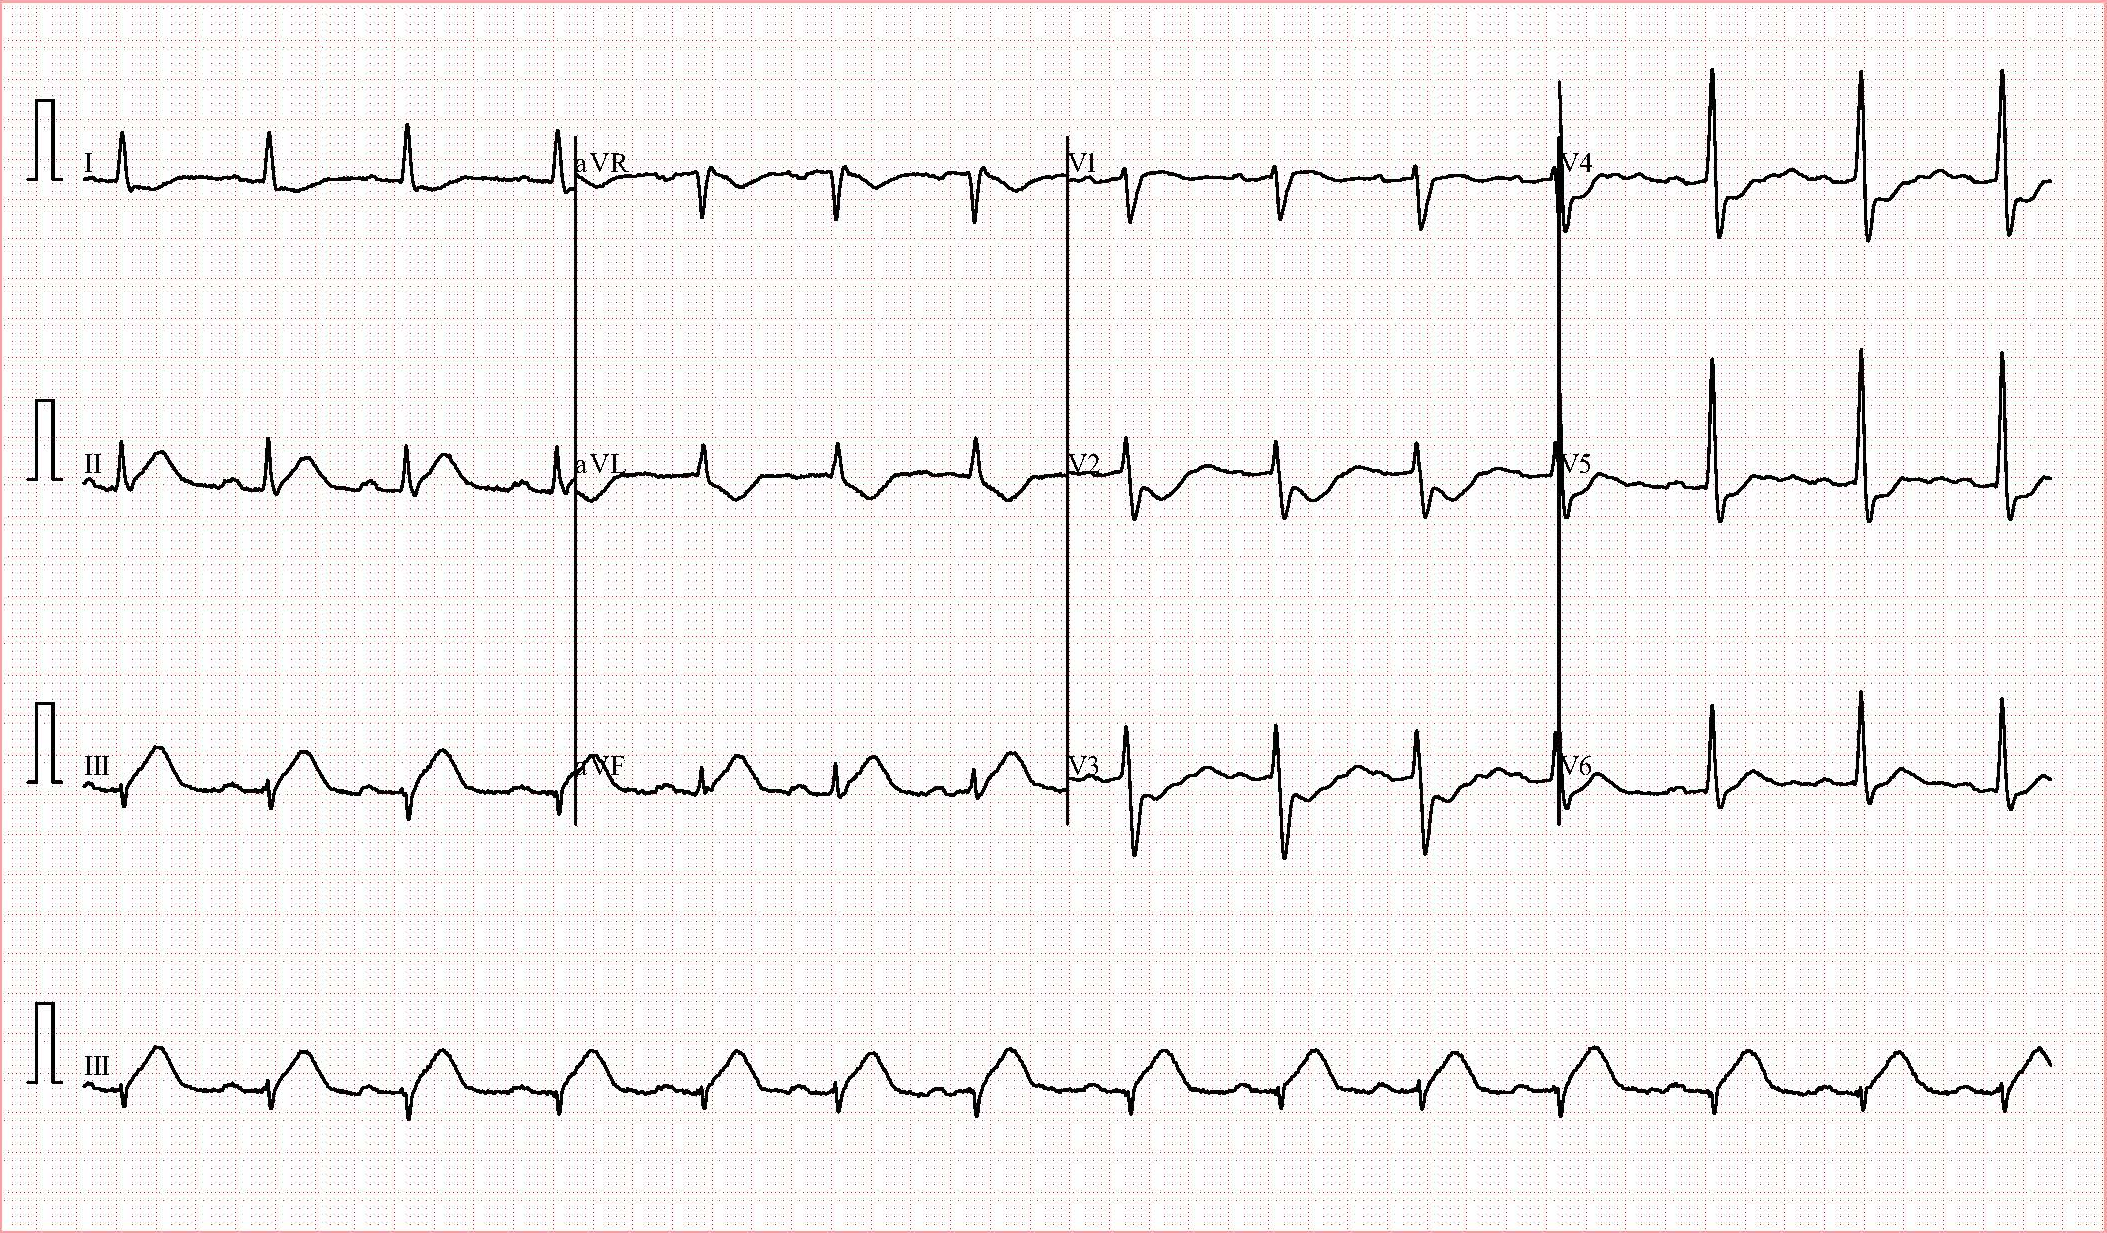

Parte 1 shape: (305, 2107, 3)


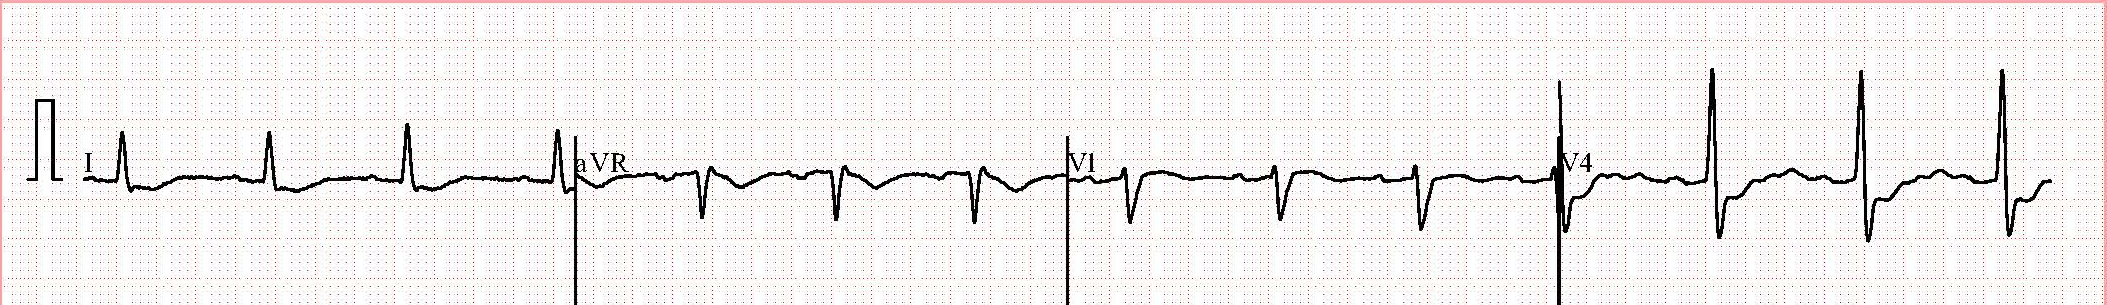

Parte 2 shape: (309, 2107, 3)


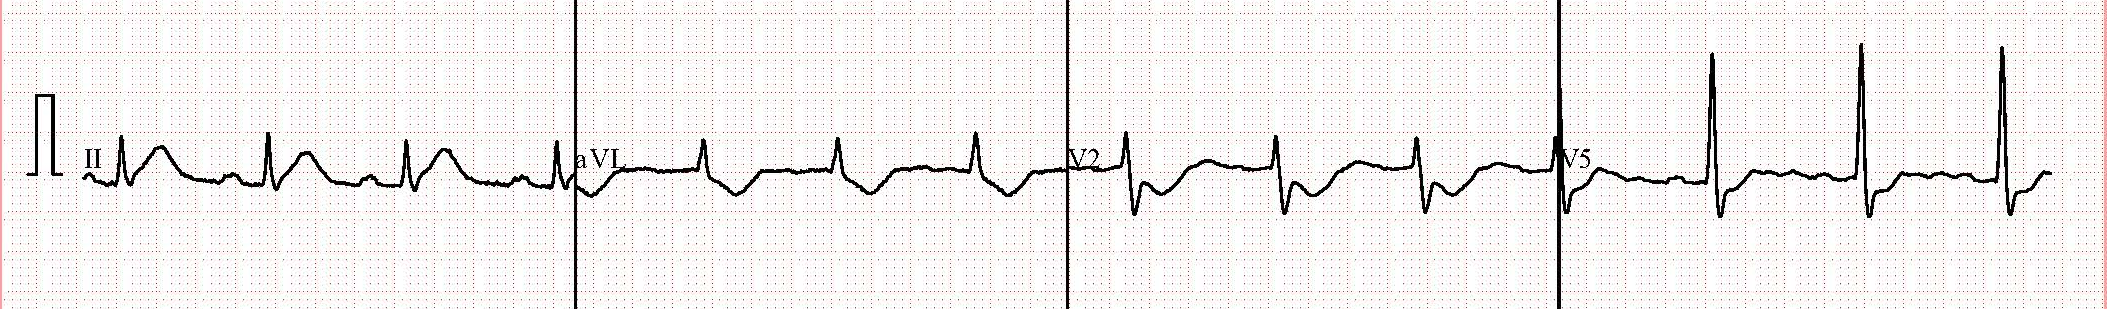

Parte 3 shape: (310, 2107, 3)


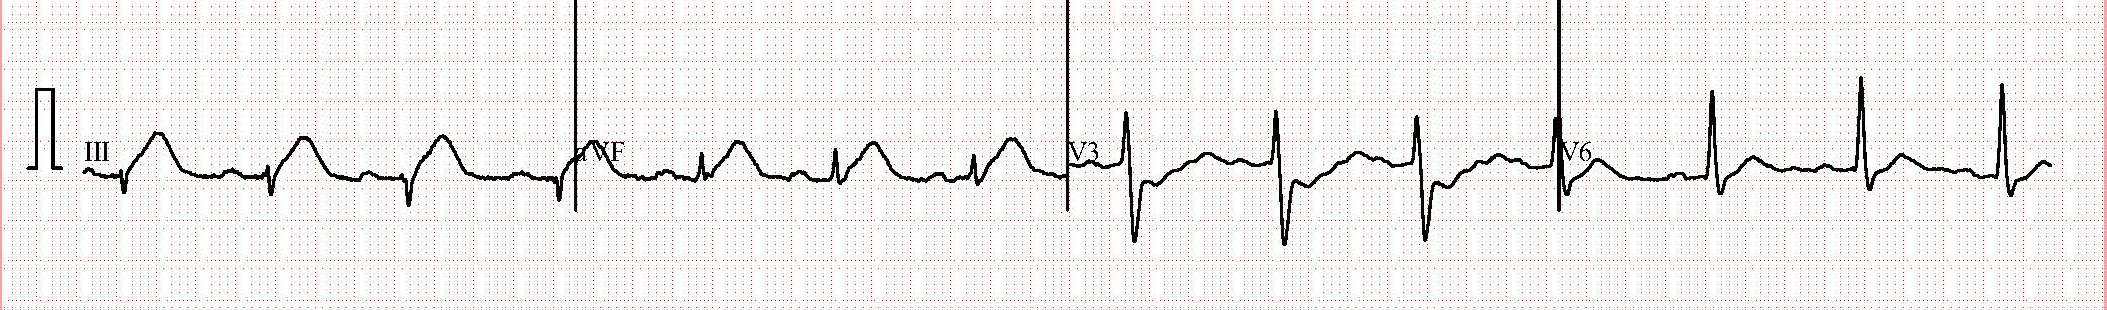

Parte 4 shape: (309, 2107, 3)


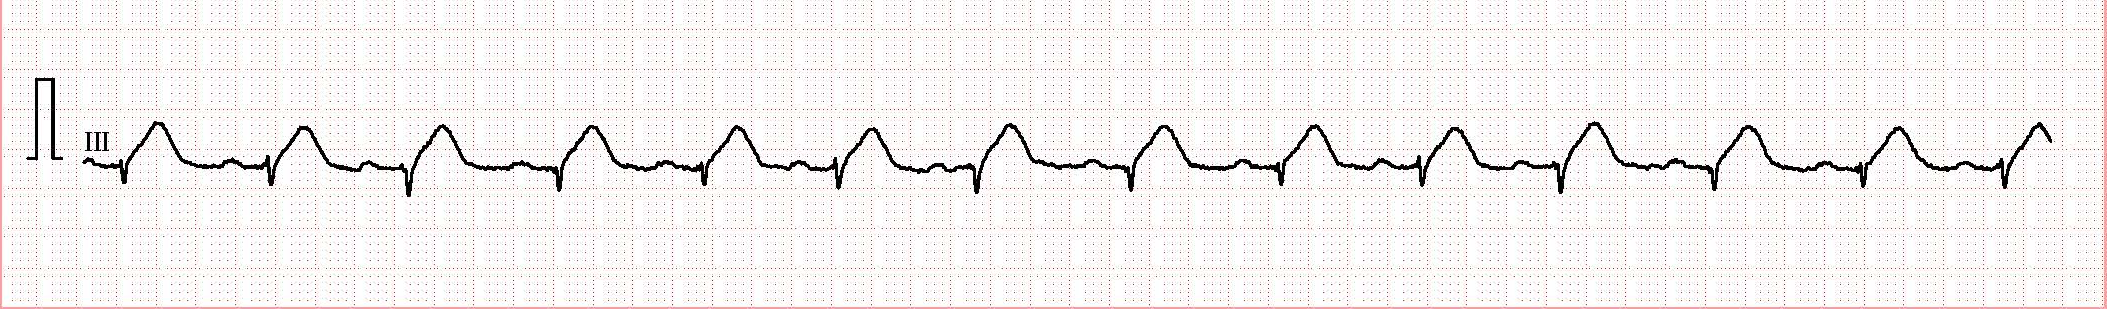

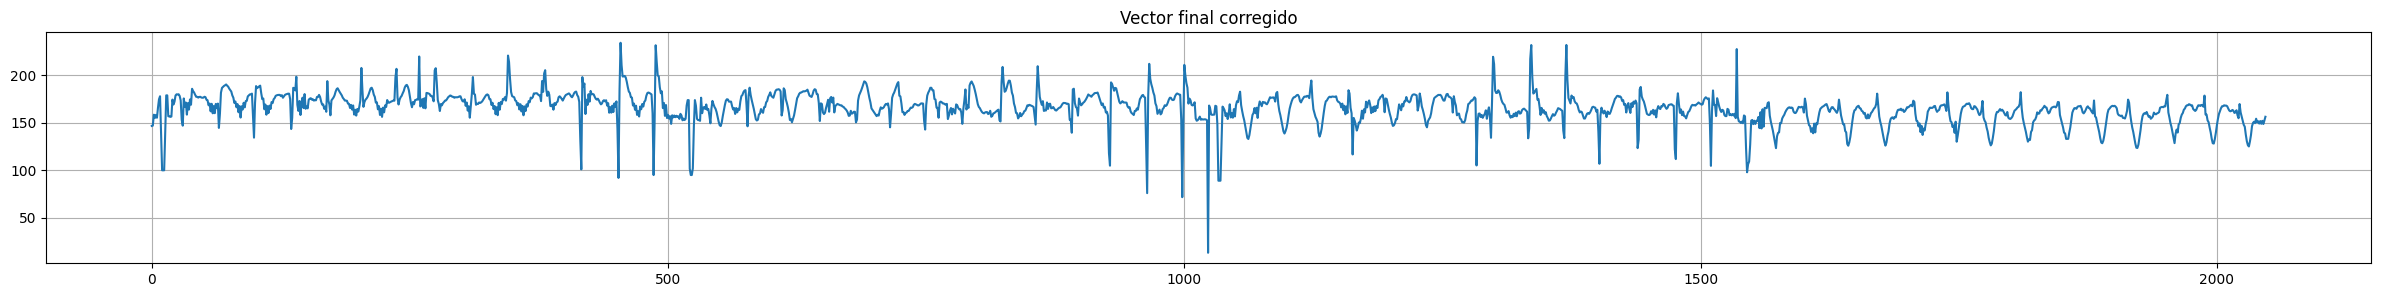

(array([146.75   , 147.1034 , 158.61967, ..., 148.80077, 152.38533,
        156.42857], dtype=float32),
 [array([[[228, 158, 166],
          [223, 148, 155],
          [226, 150, 154],
          ...,
          [252, 156, 168],
          [255, 158, 171],
          [246, 166, 177]],
  
         [[246, 177, 182],
          [253, 177, 181],
          [255, 188, 191],
          ...,
          [255, 163, 172],
          [255, 164, 176],
          [252, 171, 180]],
  
         [[217, 157, 157],
          [228, 160, 159],
          [245, 175, 173],
          ...,
          [254, 180, 179],
          [250, 174, 176],
          [239, 173, 177]],
  
         ...,
  
         [[242, 161, 168],
          [238, 167, 173],
          [255, 241, 241],
          ...,
          [231, 167, 165],
          [248, 168, 171],
          [220, 145, 149]],
  
         [[242, 161, 168],
          [238, 167, 173],
          [255, 241, 241],
          ...,
          [230, 166, 164],
          [240, 160, 163],
     

In [21]:
show_parts_and_vector_colab("/content/MI(1).jpg")


In [ ]:
roi.shape


(1233, 2107, 3)

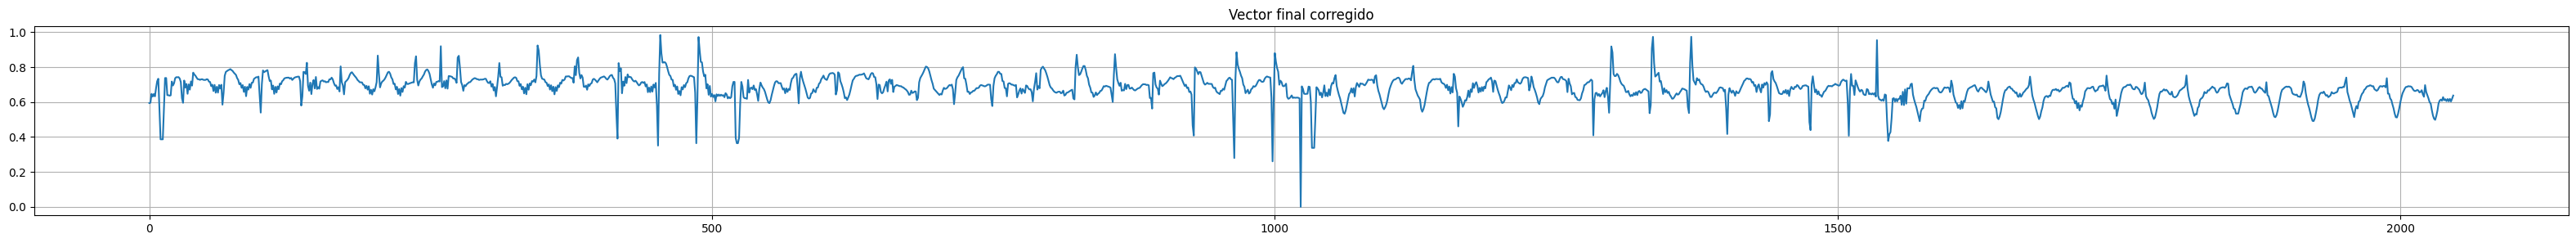

In [24]:
final = ecg_to_vector("/content/MI(1).jpg")
plt.figure(figsize=(40,3))
plt.plot(final)
plt.title("Vector final corregido")
plt.grid(True)
plt.show()

In [ ]:
def preprocess_dataset_1d(dataset_path, target_len=2048, num_rows=4):

    #Carga todas las imágenes del dataset y genera vectores 1D concatenados.

    train_dir = os.path.join(dataset_path, 'train')
    test_dir = os.path.join(dataset_path, 'test')

    X_train, y_train = [], []
    X_test, y_test = [], []

    class_names = sorted(os.listdir(train_dir))
    print(f"📂 Clases detectadas: {class_names}")

    # --- TRAIN ---
    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(train_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Procesando {cls} (train)"):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            vec = ecg_to_vector(path, target_len)

            X_train.append(vec)
            y_train.append(label)

    # --- TEST ---
    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(test_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Procesando {cls} (test)"):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            vec = ecg_to_vector(path, target_len)

            if vec is None:
                continue
            X_test.append(vec)
            y_test.append(label)

    X_train = np.array(X_train)[..., np.newaxis]
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))
    X_test = np.array(X_test)[..., np.newaxis]
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

    # --- VALIDATION ---
    # X_val se creará a partir de X_train.
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train.argmax(axis=1)
    )

    print(f"✅ X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def build_ecg_1d_model(input_length=2048, num_classes=4):

    #Construye el modelo CNN 1D
    model = models.Sequential([
        layers.Input(shape=(input_length,)),
        # Reshape para añadir el canal (necesario para Conv1D)
        layers.Reshape((input_length, 1)),

        layers.Conv1D(64, 7, activation='relu', padding='same'),
        layers.Conv1D(64, 7, activation='relu', padding='same'),
        layers.MaxPooling1D(2),

        layers.Conv1D(128, 5, activation='relu', padding='same'),
        layers.MaxPooling1D(2),

        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling1D(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
dataset_path = "/content/BeatAI/data/ECG_DATA"
TARGET_VECTOR_LENGTH = 2048
NUM_CLASSES = 4


X_train, y_train, X_val, y_val, X_test, y_test = preprocess_dataset_1d(
    dataset_path
)




📂 Clases detectadas: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (train): 100%|██████████| 956/956 [02:17<00:00,  6.97it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (train): 100%|██████████| 516/516 [01:14<00:00,  6.95it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (train): 100%|██████████| 699/699 [01:38<00:00,  7.08it/s]
Procesando Normal Person ECG Images (284x12=3408) (train): 100%|██████████| 852/852 [01:57<00:00,  7.24it/s]
Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (test): 100%|██████████| 239/239 [00:33<00:00,  7.04it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (test): 100%|██████████| 172/172 [00:24<00:00,  7.06it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (test): 100%|██████████| 233/233 [00:32<00:00,  7.17it/s]
Procesando Normal Person ECG Images (284x12=3408) (test): 100%|██████████| 284/284 [00:39<00:00,  7.21it/s

✅ X_train: (2418, 2048, 1), X_val: (605, 2048, 1), X_test: (928, 2048, 1)


In [ ]:
# Construir el modelo
model = build_ecg_1d_model(
    input_length=TARGET_VECTOR_LENGTH,
    num_classes=NUM_CLASSES
)



In [ ]:
model.summary()

print("\nIniciando entrenamiento...")
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)]
)

# Evaluar en el conjunto de test (limpio)
print("\nEvaluando en el conjunto de test (limpio)...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_7 (Reshape)             │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 2048, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 2048, 64)       │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 1024, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 512, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 512, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,926 (2.32 MB)

 Trainable params: 202,308 (790.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 404,618 (1.54 MB)


Iniciando entrenamiento...
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9912 - loss: 0.0299 - val_accuracy: 0.9950 - val_loss: 0.0180
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9912 - loss: 0.0304 - val_accuracy: 0.9934 - val_loss: 0.0270
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9838 - loss: 0.0424 - val_accuracy: 0.9868 - val_loss: 0.0285
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9944 - loss: 0.0175 - val_accuracy: 0.9950 - val_loss: 0.0192
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9895 - loss: 0.0256 - val_accuracy: 0.9835 - val_loss: 0.0376
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9833 - loss: 0.0473 - val_accuracy: 0.8017 - val_loss: 0.5747
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9596 - loss: 0.1109 - val_accuracy: 0.9901 - val_loss: 0.0314
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9835 - los

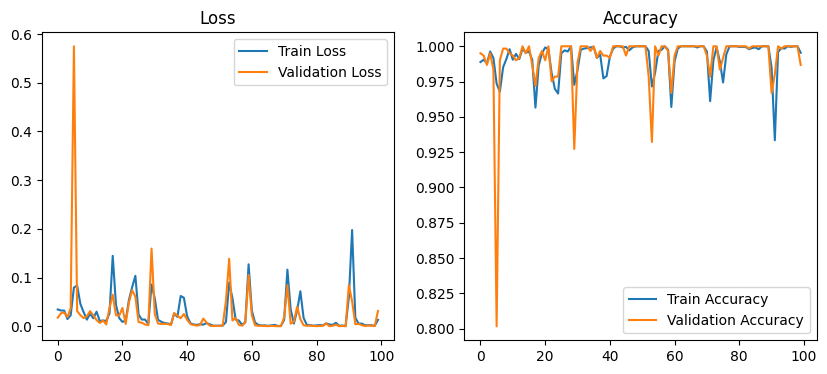

In [ ]:
def show_graphs(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

show_graphs(history)

In [ ]:
model.save("models/ecg_modelVectoreLowResolution2.h5")

In [ ]:
#!git push origin main